<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep26-eda-modeling-submission?scriptVersionId=155664602" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

[6. Baseline Modeling 2.0](#6)

[7. Baseline Modeling 3.0](#7)

[8. Ensemble Modeling](#8)


<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

- Version 1 (12/04/2023)
    * EDA 
    * Baseline modeling 1.0.
    

- Version 2 (12/05/2023)
    * Baseline modeling 1.0 updated.
    
    
- Version 3 (12/07/2023)
    * Baseline modeling 1.0 updated.
    
    
- Version 4 (12/08/2023)
    * Adding original dataset.
    * Baseline modeling 1.0 updated.
    
    
- Version 5 (12/12/2023)
    * Baseline modeling 2.0 added.
    * Ensemble modeling added.
    

- Version 6 (12/13/2023)
    * Fixing bug in baseline modeling 2.0.
    
    
- Version 7 (12/19/2023)
    * Baseline modeing 3.0 added.
    
    
- Version 8 (12/19/2023)
    * Fixing minor bugs in baseline modeling 3.0.
    
<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e26/train.csv')
test = pd.read_csv('../input/playground-series-s3e26/test.csv')
submission = pd.read_csv('../input/playground-series-s3e26/sample_submission.csv')

original = pd.read_csv('../input/cirrhosis-patient-survival-prediction/cirrhosis.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)
print('The dimension of the original dataset is:', original.shape)

The dimension of the train dataset is: (7905, 20)
The dimension of the test dataset is: (5271, 19)
The dimension of the original dataset is: (418, 20)


In [3]:
train.describe()

id       N_Days           Age    Bilirubin  Cholesterol  \
count  7905.000000  7905.000000   7905.000000  7905.000000  7905.000000   
mean   3952.000000  2030.173308  18373.146490     2.594485   350.561923   
std    2282.121272  1094.233744   3679.958739     3.812960   195.379344   
min       0.000000    41.000000   9598.000000     0.300000   120.000000   
25%    1976.000000  1230.000000  15574.000000     0.700000   248.000000   
50%    3952.000000  1831.000000  18713.000000     1.100000   298.000000   
75%    5928.000000  2689.000000  20684.000000     3.000000   390.000000   
max    7904.000000  4795.000000  28650.000000    28.000000  1775.000000   

           Albumin       Copper      Alk_Phos         SGOT  Tryglicerides  \
count  7905.000000  7905.000000   7905.000000  7905.000000    7905.000000   
mean      3.548323    83.902846   1816.745250   114.604602     115.340164   
std       0.346171    75.899266   1903.750657    48.790945      52.530402   
min       1.960000     4.000000    289.000000    26.350000      33.000000   
25%       3.350000    39.000000    834.000000    75.950000      84.000000   
50%       3.580000    63.000000   1181.000000   108.500000     104.000000   
75%       3.770000   102.000000   1857.000000   137.950000     139.000000   
max       4.640000   588.000000  13862.400000   457.250000     598.000000   

         Platelets  Prothrombin        Stage  
count  7905.000000  7905.000000  7905.000000  
mean    265.228969    10.629462     3.032511  
std      87.465579     0.781735     0.866511  
min      62.000000     9.000000     1.000000  
25%     211.000000    10.000000     2.000000  
50%     265.000000    10.600000     3.000000  
75%     316.000000    11.000000     4.000000  
max     563.000000    18.000000     4.000000

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [5]:
test.describe()

id       N_Days           Age    Bilirubin  Cholesterol  \
count   5271.000000  5271.000000   5271.000000  5271.000000  5271.000000   
mean   10540.000000  2038.696642  18497.756782     2.600389   352.486435   
std     1521.750965  1086.843490   3583.898801     3.852395   200.438989   
min     7905.000000    41.000000   9598.000000     0.300000   120.000000   
25%     9222.500000  1234.000000  15730.000000     0.700000   248.000000   
50%    10540.000000  1882.000000  18806.000000     1.100000   299.000000   
75%    11857.500000  2692.000000  20684.000000     3.000000   390.000000   
max    13175.000000  4795.000000  28650.000000    28.000000  1775.000000   

           Albumin       Copper      Alk_Phos         SGOT  Tryglicerides  \
count  5271.000000  5271.000000   5271.000000  5271.000000    5271.000000   
mean      3.538071    84.701679   1811.233314   113.587526     115.286094   
std       0.354886    77.542064   1935.351492    48.964789      52.602780   
min       1.960000     4.000000    289.000000    26.350000      33.000000   
25%       3.350000    39.000000    823.000000    75.000000      84.000000   
50%       3.570000    65.000000   1142.000000   106.950000     104.000000   
75%       3.770000   102.000000   1838.500000   137.950000     138.000000   
max       4.640000   588.000000  13862.400000   457.250000     598.000000   

         Platelets  Prothrombin        Stage  
count  5271.000000  5271.000000  5271.000000  
mean    264.023715    10.632865     3.036995  
std      87.584068     0.792711     0.856030  
min      62.000000     9.000000     1.000000  
25%     209.000000    10.000000     2.000000  
50%     259.000000    10.600000     3.000000  
75%     317.000000    11.000000     4.000000  
max     563.000000    15.200000     4.000000

There are no missing values neither in `train` and `test` datasets.

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

Notice that the data exploration is based on the competition dataset. First, we start by visualizing `Status`, the variable of interest.

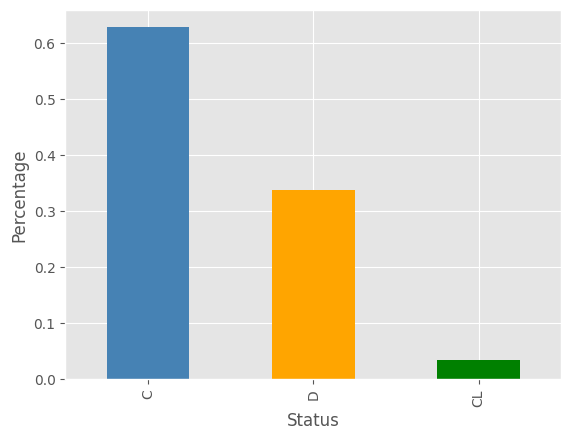

In [6]:
train['Status'].value_counts(normalize = True).plot(kind = 'bar', color = ['steelblue', 'orange', 'green'])
plt.ylabel('Percentage');

From the above chart, it is clear that the dataset is imbalanced.

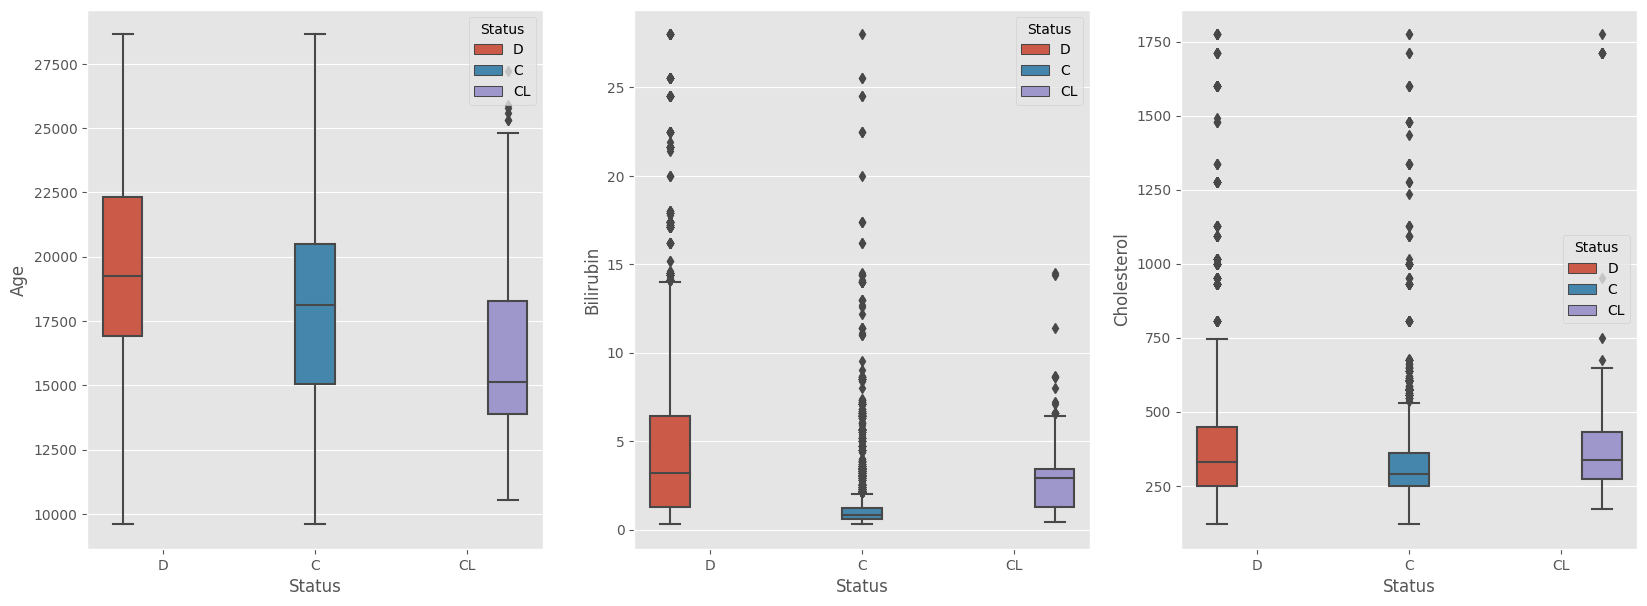

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (20, 7))

sns.boxplot(ax = axes[0], data = train, x = 'Status', y = 'Age', hue = 'Status');
sns.boxplot(ax = axes[1], data = train, x = 'Status', y = 'Bilirubin', hue = 'Status');
sns.boxplot(ax = axes[2], data = train, x = 'Status', y = 'Cholesterol', hue = 'Status');

From the above charts, these are some observations:

- In the left panel, it seems that there is a pattern between `Age` and `Status`. As we move from left to right, the median `Age` decreases.
- In the middle panel, we see there are many outliers. Also, we can see the median `Bilirubin`  of `Status = C` is smaller compared to the other two status.
- In the right panel, we see there are many outliers. Also, there is no much difference between the medians `Cholesterol` of the three groups.

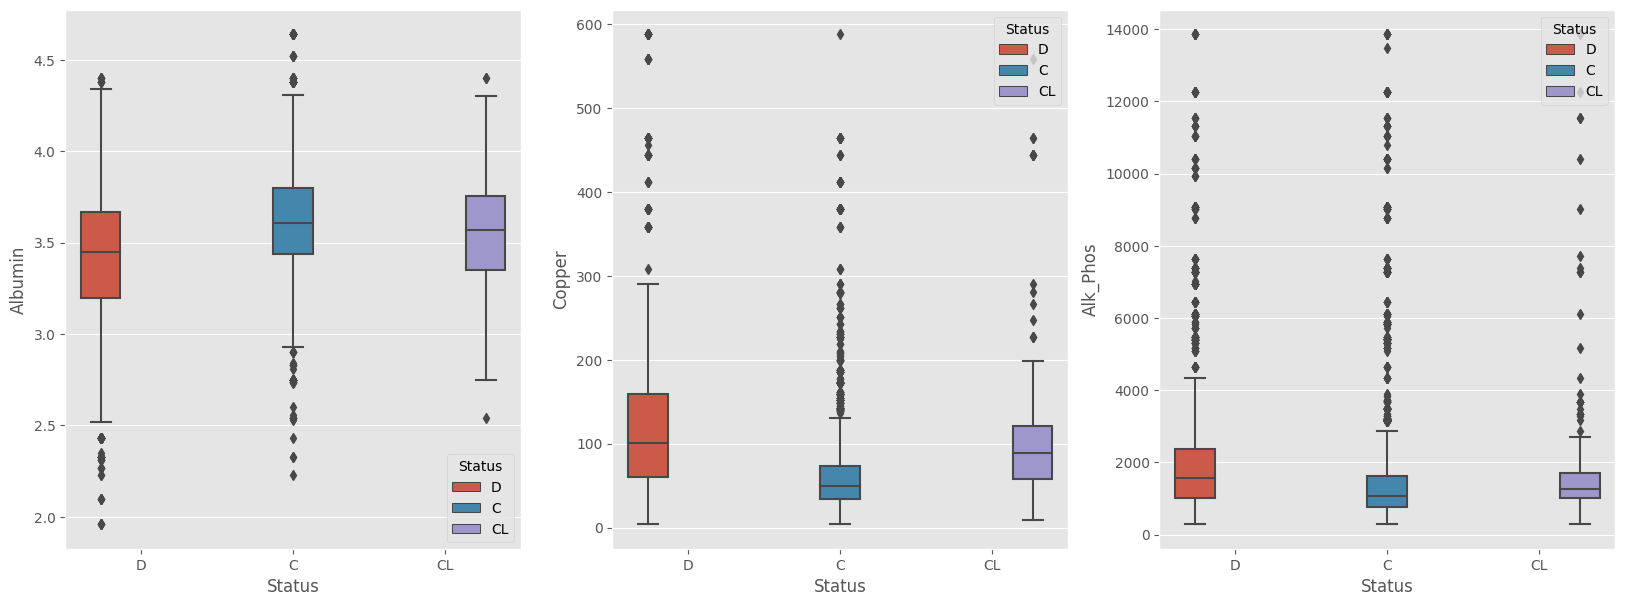

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (20, 7))

sns.boxplot(ax = axes[0], data = train, x = 'Status', y = 'Albumin', hue = 'Status');
sns.boxplot(ax = axes[1], data = train, x = 'Status', y = 'Copper', hue = 'Status');
sns.boxplot(ax = axes[2], data = train, x = 'Status', y = 'Alk_Phos', hue = 'Status');

From the above charts, these are some observations:

- In the left panel, the medians `Albumin` of `Status = C` and `Status = CL` are higher compared to the medians `Albumin` of `Status = D`.
- In the middle panel, the median `Copper` of `Status = C` is smaller compared to the other two groups.
- In the right panel, the distribution of the three `Status` groups are similar.

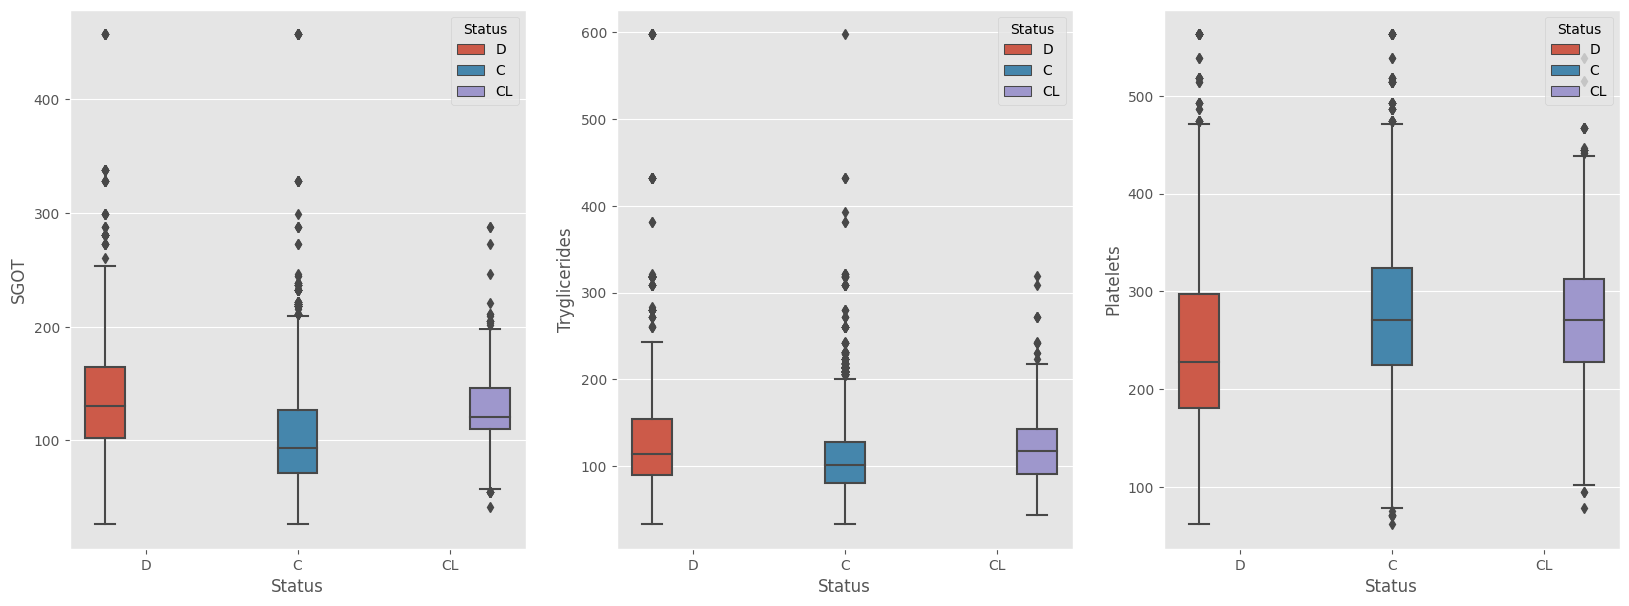

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (20, 7))

sns.boxplot(ax = axes[0], data = train, x = 'Status', y = 'SGOT', hue = 'Status');
sns.boxplot(ax = axes[1], data = train, x = 'Status', y = 'Tryglicerides', hue = 'Status');
sns.boxplot(ax = axes[2], data = train, x = 'Status', y = 'Platelets', hue = 'Status');

From the above charts, these are a couple of observations:

- In the left panel, the median `SGOT` of `Status = C` is smaller compared to the other two groups.
- In the middel panel, the median `Tryglicerides` if `Status = C` is slightly smaller compared to the other two groups.
- In the right panel, the median `Platelets` of `Status = D` is smaller compared to the other two groups.

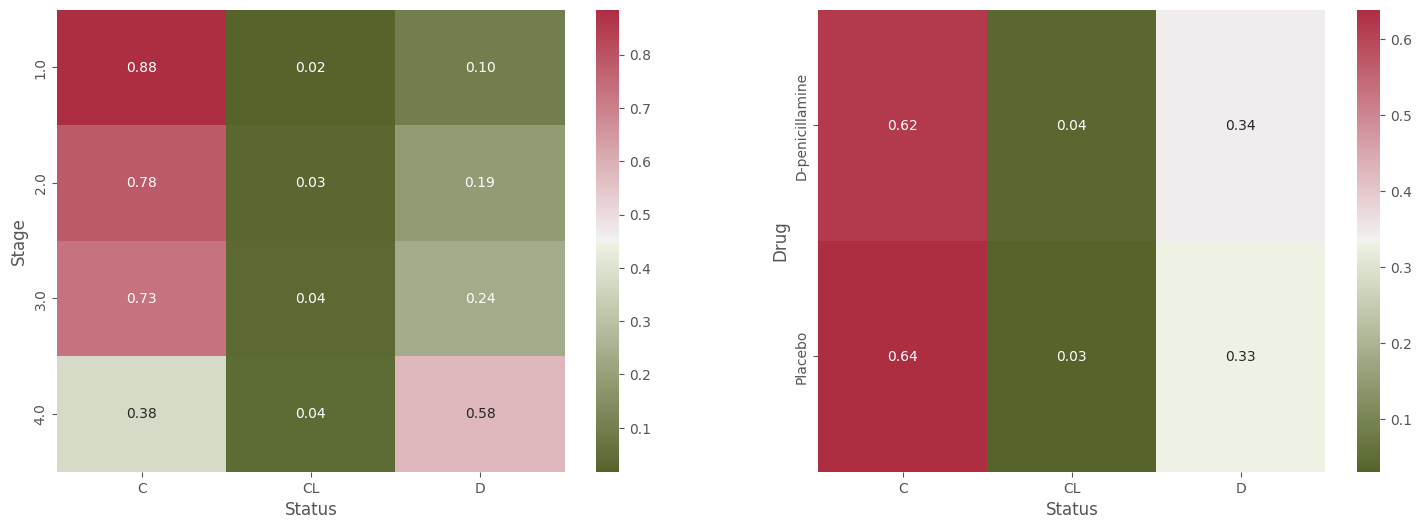

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['Stage'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['Drug'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above charts, these are a couple of observations:

- In the left panel, `Stage = 4` has the highest percentage of `Status = D` compared to the other `Stage` groups.
- In the right panel, both `Drug` group have similar `Status = D` percentages.

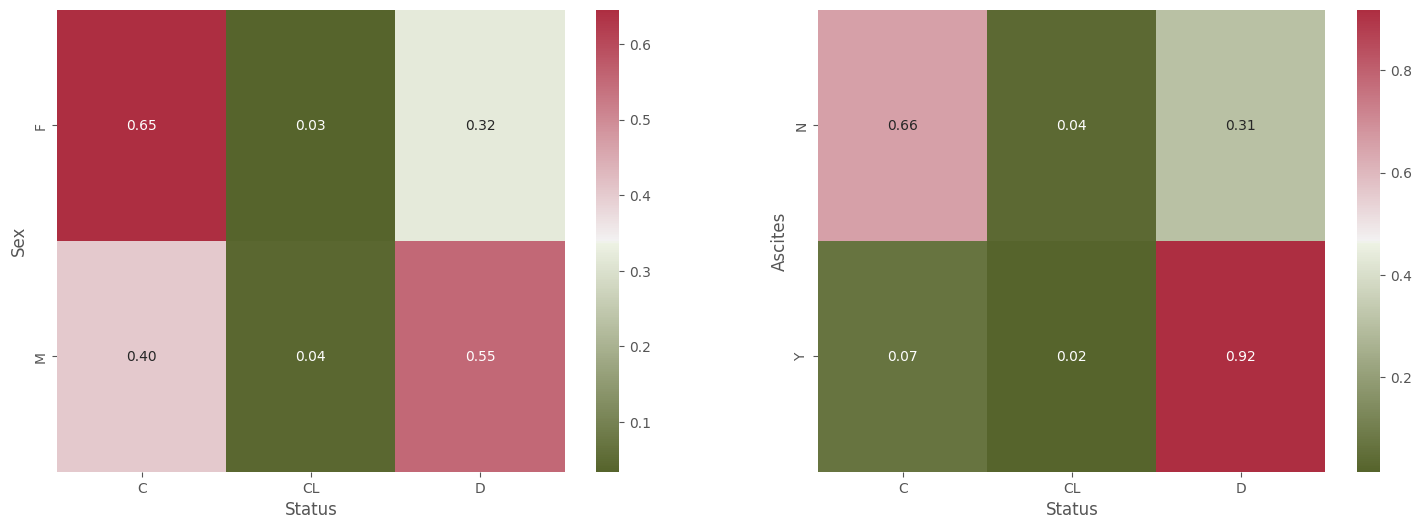

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['Sex'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['Ascites'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above charts, these are a couple of observations:

- In the left panel, males have a higher percentage of `Status = D` compared to males. 
- In the right panel, when `Ascites = Y` the percentage of `Status = D` is higher.

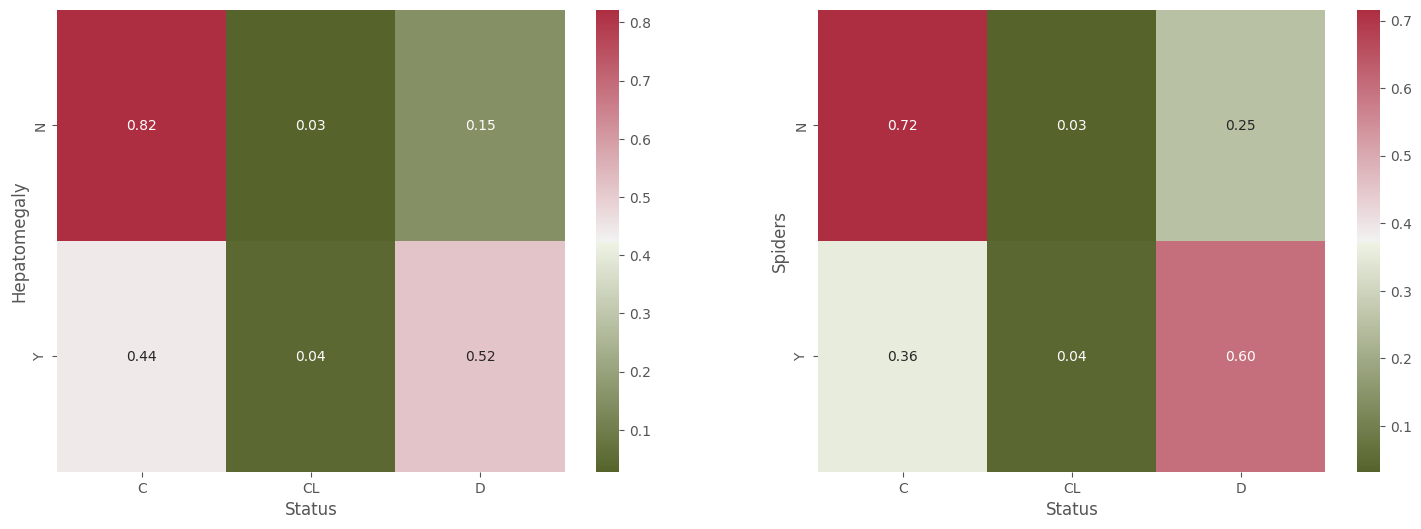

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

sns.heatmap(ax = axes[0], data = pd.crosstab(train['Hepatomegaly'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');
sns.heatmap(ax = axes[1], data = pd.crosstab(train['Spiders'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above charts, these are a couple of observations:

- In the left panel, when `Hepatomegaly = Y`, the percentage of `Status = D` is higher compared when `Hepatomegaly = N`
- In the right panel, when `Spiders = Y`, the percentage of `Status = D` is higher compared when `Spiders = N`

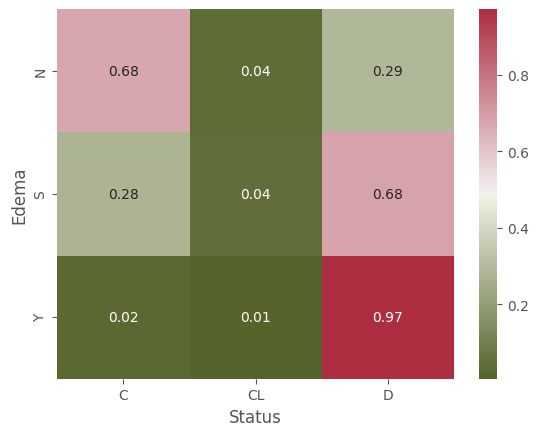

In [13]:
sns.heatmap(data = pd.crosstab(train['Edema'], train['Status'], normalize = 'index'), annot = True, cmap = cmap, fmt = '.2f');

From the above chart, we see that when `Edema = Y` the percentage of `Status = D` is higher compared to the other two `Edema` categories.

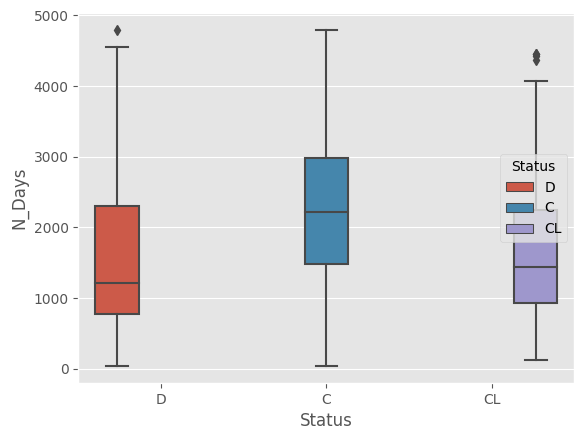

In [14]:
sns.boxplot(data = train, x = 'Status', y = 'N_Days', hue = 'Status');

From the above chart, the median of `N_Days` of `Status = C` is higher compared to the other `Status` categories. 

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

We start by modeling (using standard models) with raw data with minimum transformation. First, we define the input, target variables and the cross-validation folds.

In [15]:
train = train.drop(columns = 'id', axis = 1)
train['generated'] = 1

test = test.drop(columns = 'id', axis = 1)
test['generated'] = 1

original = original.drop(columns = 'ID', axis = 1)
original = original.dropna()
original['generated'] = 0

train = pd.concat([train, original], axis = 0).reset_index(drop = True)

X = train.drop(columns = ['Edema', 'Status'], axis = 1)
X['Drug'] = X['Drug'].map({'D-penicillamine': 0, 'Placebo': 1})
X['Sex'] = X['Sex'].map({'F': 0, 'M': 1})
X['Ascites'] = X['Ascites'].map({'N': 0, 'Y': 1})
X['Hepatomegaly'] = X['Hepatomegaly'].map({'N': 0, 'Y': 1})
X['Spiders'] = X['Spiders'].map({'N': 0, 'Y': 1})
X = pd.concat([X, pd.get_dummies(train['Edema'], drop_first = True, dtype = int)], axis = 1)

Y = train['Status'].map({'C': 0, 'CL': 1, 'D': 2})

test_md = test.drop(columns = ['Edema'], axis = 1)
test_md['Drug'] = test_md['Drug'].map({'D-penicillamine': 0, 'Placebo': 1})
test_md['Sex'] = test_md['Sex'].map({'F': 0, 'M': 1})
test_md['Ascites'] = test_md['Ascites'].map({'N': 0, 'Y': 1})
test_md['Hepatomegaly'] = test_md['Hepatomegaly'].map({'N': 0, 'Y': 1})
test_md['Spiders'] = test_md['Spiders'].map({'N': 0, 'Y': 1})
test_md = pd.concat([test_md, pd.get_dummies(test['Edema'], drop_first = True, dtype = int)], axis = 1)

skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

First, we train the `LogistiRegression` model.

In [16]:
%%time
logit_cv = cross_val_score(make_pipeline(PowerTransformer(), LogisticRegression(multi_class = 'ovr',
                                                                                max_iter = 1000)), 
                           X, 
                           Y, 
                           scoring = 'neg_log_loss',
                           cv = skf, 
                           n_jobs = -1)

print(f"The 10-folds oof Log-Loss score is {-1*logit_cv.mean()}")

The 10-folds oof Log-Loss score is 0.5126954515124376
CPU times: user 117 ms, sys: 89.5 ms, total: 207 ms
Wall time: 3.25 s


Next, we train the `RandomForestClassifier` model.

In [17]:
%%time
RF_cv = cross_val_score(RandomForestClassifier(**{'n_estimators': 1000,
                                                  'criterion': 'log_loss',
                                                  'max_depth': 14,
                                                  'min_samples_split': 3,
                                                  'min_samples_leaf': 1,
                                                  'max_features': 4,
                                                  'random_state': 1,
                                                  'n_jobs': -1}),
                        X, 
                        Y, 
                        scoring = 'neg_log_loss',
                        cv = skf, 
                        n_jobs = -1)

print(f"The 10-folds oof Log-Loss score of the RF is {-1*RF_cv.mean()}")

The 10-folds oof Log-Loss score of the RF is 0.4473870145671123
CPU times: user 319 ms, sys: 114 ms, total: 434 ms
Wall time: 1min 5s


Next, we train the `ExtraTreesClassifier` model.

In [18]:
%%time
ET_cv = cross_val_score(ExtraTreesClassifier(criterion = 'log_loss',
                                             n_estimators = 500, 
                                             min_samples_leaf = 3, 
                                             max_depth = 15, 
                                             random_state = 2),
                        X, 
                        Y, 
                        scoring = 'neg_log_loss',
                        cv = skf, 
                        n_jobs = -1)

print(f"The 10-folds oof Log-Loss score of the ET is {-1*ET_cv.mean()}")

The 10-folds oof Log-Loss score of the ET is 0.49305652728810523
CPU times: user 115 ms, sys: 35.4 ms, total: 150 ms
Wall time: 14.1 s


Next, we train the `HistGradientBoostingClassifier` model.

In [19]:
%%time
HB_cv = cross_val_score(HistGradientBoostingClassifier(**{'l2_regularization': 8.876168706639714,
                                                          'early_stopping': False,
                                                          'learning_rate': 0.009956485590638034,
                                                          'max_iter': 500,
                                                          'max_depth': 16,
                                                          'max_bins': 255,
                                                          'min_samples_leaf': 16,
                                                          'max_leaf_nodes': 18,
                                                          'random_state': 3}),
                        X, 
                        Y, 
                        scoring = 'neg_log_loss',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the HG is {-1*HB_cv.mean()}")

The average 10-folds oof Log-Loss score of the HG is 0.4382578304850213
CPU times: user 193 ms, sys: 61.5 ms, total: 255 ms
Wall time: 30.4 s


Next, we train the `LGBMClassifier` model.

In [20]:
%%time
LGBM_cv = cross_val_score(LGBMClassifier(**{'n_estimators': 1000,
                                            'learning_rate': 0.013657589160895923,
                                            'max_depth': 17,
                                            'reg_alpha': 1.9791969860931342,
                                            'reg_lambda': 1.2857088172765347,
                                            'num_leaves': 37,
                                            'subsample': 0.6351453342675659,
                                            'colsample_bytree': 0.2644509924064132}),
                          X,
                          Y,
                          scoring = 'neg_log_loss',
                          cv = skf, 
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the LGBM model is {-1*LGBM_cv.mean()}") 

The average 10-folds oof Log-Loss score of the LGBM model is 0.41898862308530027
CPU times: user 399 ms, sys: 157 ms, total: 557 ms
Wall time: 1min 5s


Next, we train the `XGBClassifer` model.

In [21]:
%%time
XGB_cv = cross_val_score(XGBClassifier(**{'max_depth': 7,
                                          'learning_rate': 0.03570188608151033,
                                          'n_estimators': 1000,
                                          'gamma': 0.6440001307764849,
                                          'min_child_weight': 2,
                                          'colsample_bytree': 0.27034458854562116,
                                          'subsample': 0.8435412915999765}), 
                          X,
                          Y,
                          scoring = 'neg_log_loss',
                          cv = skf, 
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the XGBoost model is {-1*XGB_cv.mean()}") 

The average 10-folds oof Log-Loss score of the XGBoost model is 0.4192049807099618
CPU times: user 290 ms, sys: 93.6 ms, total: 383 ms
Wall time: 44.6 s


Next, we train the `CatBoostClassifer` model.

In [22]:
Cat_cv = cross_val_score(CatBoostClassifier(loss_function = 'MultiClass',
                                            iterations = 2000,
                                            learning_rate = 0.01,
                                            depth = 8, 
                                            verbose = False,
                                            task_type = 'CPU'), 
                          X,
                          Y,
                          scoring = 'neg_log_loss',
                          cv = skf, 
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the CatBoost model is {-1*Cat_cv.mean()}") 


The average 10-folds oof Log-Loss score of the CatBoost model is 0.441892338533313


In [23]:
model_performance = pd.DataFrame()
model_performance['Model'] = ['Logistic', 'RF', 'ET', 'Hist', 'LGBM', 'XGBoost', 'CatBoost']
model_performance['10-folds oof Log-Loss'] = [-1*logit_cv.mean(), -1*RF_cv.mean(), -1*ET_cv.mean(), -1*HB_cv.mean(), -1*LGBM_cv.mean(), -1*XGB_cv.mean(), -1*Cat_cv.mean()]
print(f"The followig table shows the performance of the considered models: \n\n{model_performance}")

The followig table shows the performance of the considered models: 

      Model  10-folds oof Log-Loss
0  Logistic               0.512695
1        RF               0.447387
2        ET               0.493057
3      Hist               0.438258
4      LGBM               0.418989
5   XGBoost               0.419205
6  CatBoost               0.441892


From the above, we see that `LGBM` has the best performance in terms of the Log-Loss. We will ensemble the top four models in a weighted linear fashion as follows:   

- First, we train the models in a 10-folds cross validation framework.
- As we are training the models in the folds, we store the oof predictions of the models.
- After that, we estimate the ``*optimal weight combination*'' by selecting weights at random.

In [24]:
md1 = make_pipeline(PowerTransformer(), LogisticRegression(multi_class = 'ovr',
                                                           max_iter = 1000))

md2 = RandomForestClassifier(**{'n_estimators': 1000,
                                'criterion': 'log_loss',
                                'max_depth': 14,
                                'min_samples_split': 3,
                                'min_samples_leaf': 1,
                                'max_features': 4,
                                'random_state': 1,
                                'n_jobs': -1})

md3 = ExtraTreesClassifier(criterion = 'log_loss',
                           n_estimators = 1000, 
                           min_samples_leaf = 1, 
                           max_depth = 15, 
                           random_state = 2)

md4 = HistGradientBoostingClassifier(**{'l2_regularization': 8.876168706639714,
                                        'early_stopping': False,
                                        'learning_rate': 0.009956485590638034,
                                        'max_iter': 500,
                                        'max_depth': 16,
                                        'max_bins': 255,
                                        'min_samples_leaf': 16,
                                        'max_leaf_nodes': 18,
                                        'random_state': 3})

md5 = LGBMClassifier(**{'n_estimators': 1000,
                        'learning_rate': 0.013657589160895923,
                        'max_depth': 17,
                        'reg_alpha': 1.9791969860931342,
                        'reg_lambda': 1.2857088172765347,
                        'num_leaves': 37,
                        'subsample': 0.6351453342675659,
                        'colsample_bytree': 0.2644509924064132})

md6 = XGBClassifier(**{'max_depth': 7,
                       'learning_rate': 0.03570188608151033,
                       'n_estimators': 1000,
                       'gamma': 0.6440001307764849,
                       'min_child_weight': 2,
                       'colsample_bytree': 0.27034458854562116,
                       'subsample': 0.8435412915999765})

md7 = CatBoostClassifier(loss_function = 'MultiClass',
                         iterations = 2000,
                         learning_rate = 0.01,
                         depth = 8, 
                         verbose = False,
                         task_type = 'CPU')

In [25]:
%%time
md4_pred, md5_pred, md6_pred = list(), list(), list()
Y_test_list = list()

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    md4.fit(X_train, Y_train)
    md4_pred.append(md4.predict_proba(X_test))
    
    md5.fit(X_train, Y_train)
    md5_pred.append(md5.predict_proba(X_test))
    
    md6.fit(X_train, Y_train)
    md6_pred.append(md6.predict_proba(X_test))
    
    Y_test_list.append(Y_test)

CPU times: user 6min 31s, sys: 3min 19s, total: 9min 50s
Wall time: 7min 14s


After that, we estimate the model predictions weights as follows:

In [26]:
w4_weights, w5_weights, w6_weights = list(), list(), list()
scores = list()

for i in tqdm(range(0, 3000)):
    
    w4 = np.random.random_sample(size = 1)[0]
    w5 = np.random.random_sample(size = 1)[0]
    w6 = np.random.random_sample(size = 1)[0]
    
    w4_weights.append(w4)
    w5_weights.append(w5)
    w6_weights.append(w6)
    
    scores_in = list()
    
    for j in range(0, 10):
        
        pred = w4*md4_pred[j] + w5*md5_pred[j] + w6*md6_pred[j] 
        scores_in.append(log_loss(Y_test_list[j], pred))
    
    scores.append(np.mean(scores_in))
    
results = pd.DataFrame()
results['w_md4'] = w4_weights
results['w_md5'] = w5_weights
results['w_md6'] = w6_weights
results['score'] = scores
results = results.sort_values(by = 'score', ascending = True).reset_index(drop = True)
results.head(10)

  0%|          | 0/3000 [00:00<?, ?it/s]

w_md4     w_md5     w_md6     score
0  0.023657  0.593090  0.701376  0.417406
1  0.025141  0.651275  0.514736  0.417407
2  0.011842  0.556468  0.773546  0.417438
3  0.024519  0.509676  0.764347  0.417441
4  0.009387  0.877080  0.452672  0.417474
5  0.005195  0.611897  0.753423  0.417482
6  0.039450  0.779413  0.462580  0.417486
7  0.045740  0.755228  0.478012  0.417495
8  0.057388  0.648790  0.525978  0.417514
9  0.053827  0.528845  0.703160  0.417522

Next, we train the models in the entire data.

In [27]:
%%time
md4_fit = md4.fit(X, Y)
md5_fit = md5.fit(X, Y)
md6_fit = md6.fit(X, Y)

CPU times: user 39 s, sys: 20.1 s, total: 59.1 s
Wall time: 44.7 s


Finally, we use the weights that produce the lowest oof `Log-Loss` score to ensemble the best four model predictions.

In [28]:
ens = (results['w_md4'][0]*md4_fit.predict_proba(test_md) + 
       results['w_md5'][0]*md5_fit.predict_proba(test_md) + 
       results['w_md6'][0]*md6_fit.predict_proba(test_md))

ens = pd.DataFrame(ens)
ens = ens.div(ens.sum(axis = 1), axis = 0)

submission.loc[:, ['Status_C', 'Status_CL', 'Status_D']] = ens.values
submission.head()

id  Status_C  Status_CL  Status_D
0  7905  0.428017   0.029049  0.542935
1  7906  0.481452   0.230332  0.288217
2  7907  0.024985   0.008719  0.966296
3  7908  0.967874   0.003680  0.028446
4  7909  0.881275   0.039319  0.079407

In [29]:
submission.to_csv('baseline_sub_1.csv', index = False)

<a id="6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

In this section, we start exploring the partial dependency plots of each of the models to explore how `Drug`, `Prothrombin`, and `Alk_Phos`  are affecting each of the target classes. First, we create the dependency plots on `Status = C`.

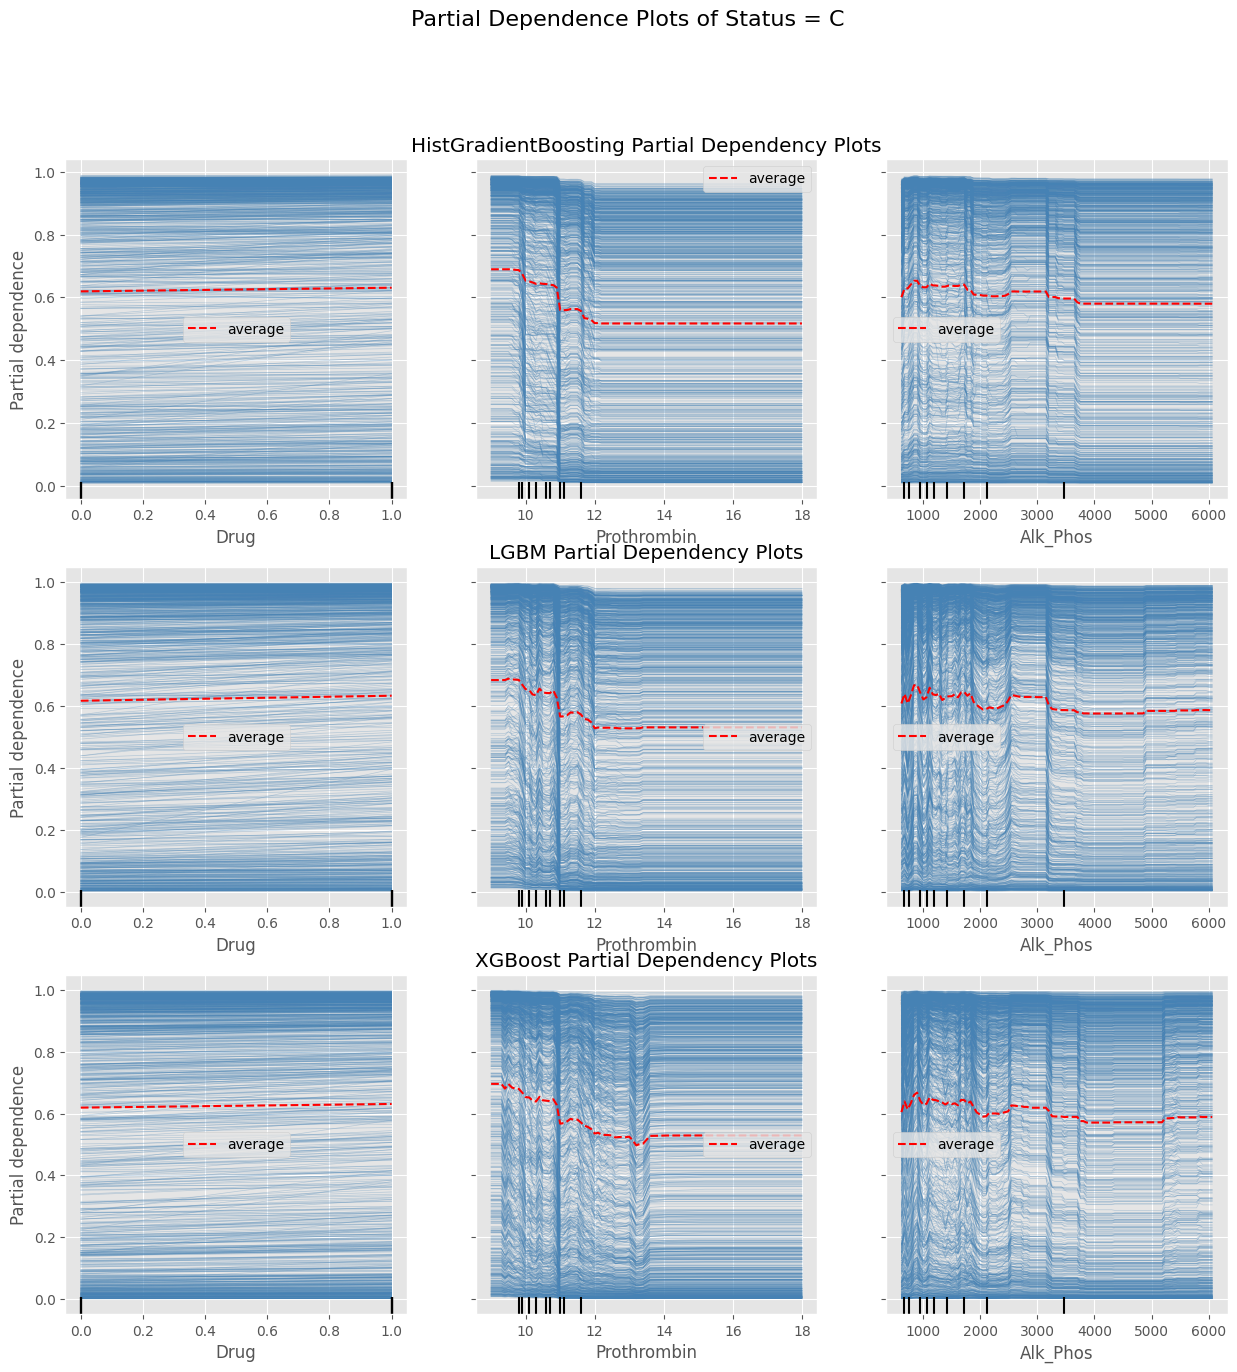

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 15))

fig.suptitle('Partial Dependence Plots of Status = C', fontsize = 16)

HG_disp = PartialDependenceDisplay.from_estimator(md4_fit, X, ['Drug', 'Prothrombin', 'Alk_Phos'],
                                                  pd_line_kw = {"color": "red"},
                                                  ice_lines_kw = {"color": "steelblue"},
                                                  kind = 'both', 
                                                  target = 0,
                                                  response_method = 'predict_proba',
                                                  ax = ax1)
ax1.set_title('HistGradientBoosting Partial Dependency Plots')

LGBM_disp = PartialDependenceDisplay.from_estimator(md5_fit, X, ['Drug', 'Prothrombin', 'Alk_Phos'],
                                                    pd_line_kw = {"color": "red"},
                                                    ice_lines_kw = {"color": "steelblue"},
                                                    kind = 'both', 
                                                    target = 0,
                                                    response_method = 'predict_proba',
                                                    ax = ax2)
ax2.set_title('LGBM Partial Dependency Plots')

XGB_disp = PartialDependenceDisplay.from_estimator(md6_fit, X, ['Drug', 'Prothrombin', 'Alk_Phos'],
                                                   pd_line_kw = {"color": "red"},
                                                   ice_lines_kw = {"color": "steelblue"},
                                                   kind = 'both', 
                                                   target = 0,
                                                   response_method = 'predict_proba',
                                                   ax = ax3)
ax3.set_title('XGBoost Partial Dependency Plots')
plt.savefig('C_partial_dependency_plots.png');

From the above plots, these are a couple of observations:

- The mean likelihood of `Status = C` is constant regardless of `Drug` label.
- When `Prothrombin >= 14`, the mean likelihood of `Status = C` is constant. 
- When `Alk_Phos >= 4000`, the mean likelihood of `Status = C` is constant.

Next, we create the dependency plots on `Status = CL`.

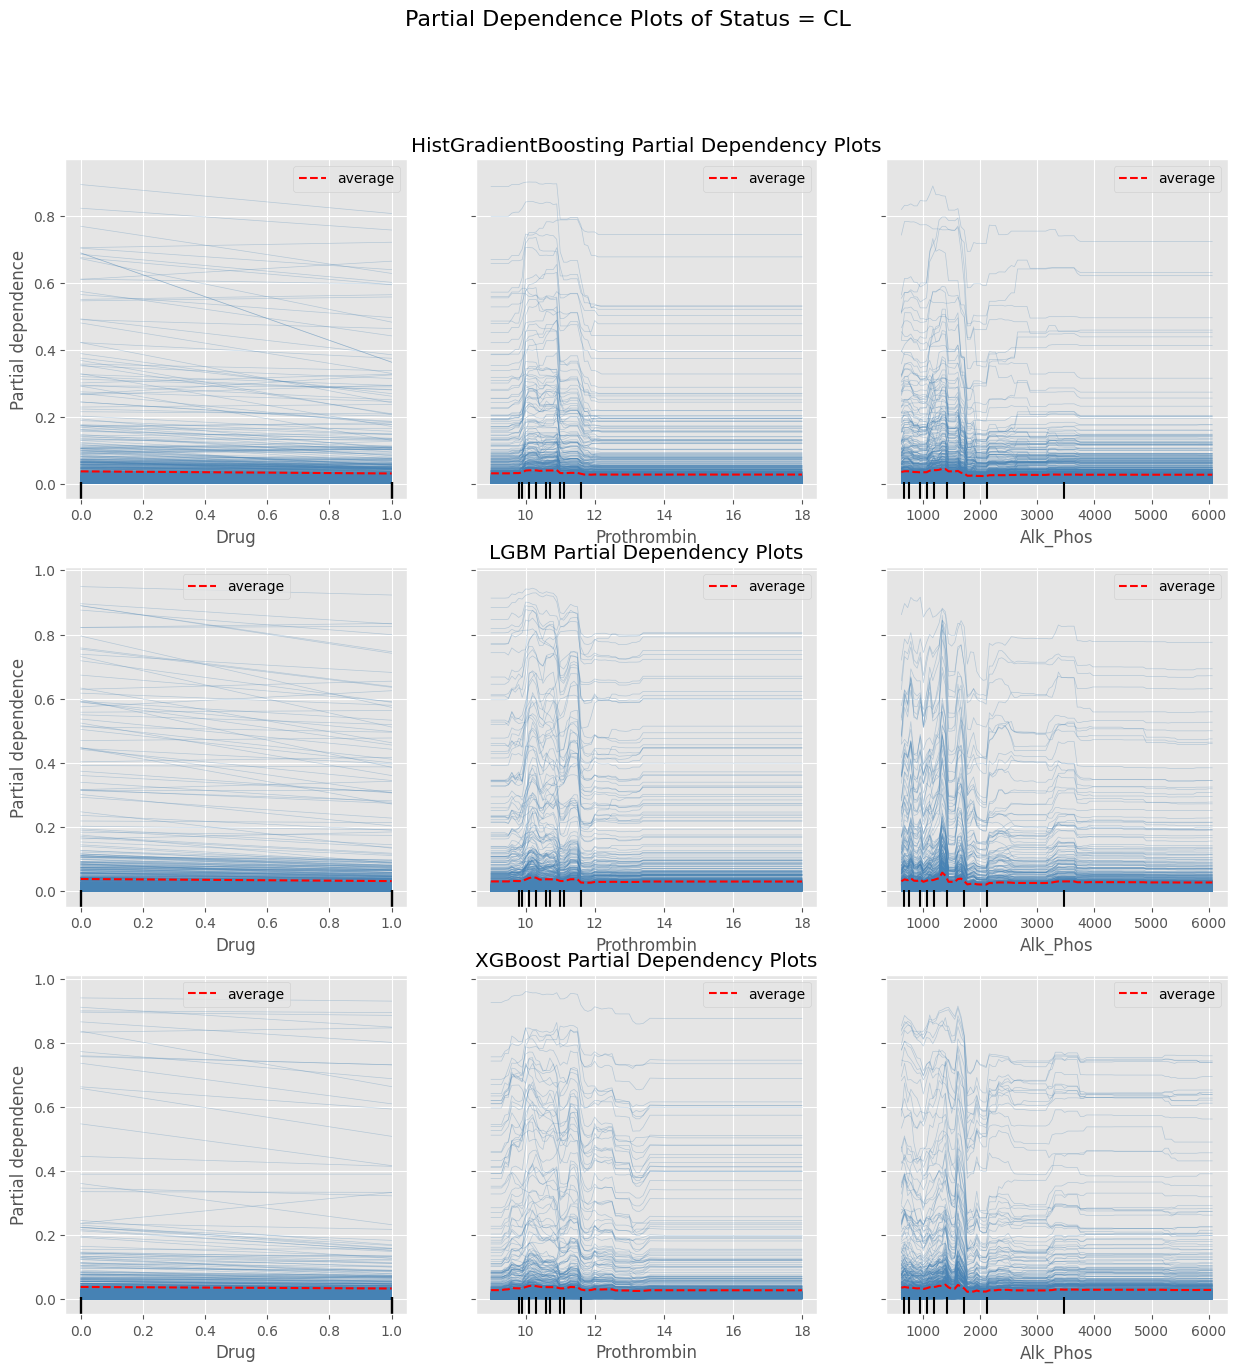

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 15))

fig.suptitle('Partial Dependence Plots of Status = CL', fontsize = 16)

HG_disp = PartialDependenceDisplay.from_estimator(md4_fit, X, ['Drug', 'Prothrombin', 'Alk_Phos'],
                                                  pd_line_kw = {"color": "red"},
                                                  ice_lines_kw = {"color": "steelblue"},
                                                  kind = 'both', 
                                                  target = 1,
                                                  response_method = 'predict_proba',
                                                  ax = ax1)
ax1.set_title('HistGradientBoosting Partial Dependency Plots')

LGBM_disp = PartialDependenceDisplay.from_estimator(md5_fit, X, ['Drug', 'Prothrombin', 'Alk_Phos'],
                                                    pd_line_kw = {"color": "red"},
                                                    ice_lines_kw = {"color": "steelblue"},
                                                    kind = 'both', 
                                                    target = 1,
                                                    response_method = 'predict_proba',
                                                    ax = ax2)
ax2.set_title('LGBM Partial Dependency Plots')

XGB_disp = PartialDependenceDisplay.from_estimator(md6_fit, X, ['Drug', 'Prothrombin', 'Alk_Phos'],
                                                   pd_line_kw = {"color": "red"},
                                                   ice_lines_kw = {"color": "steelblue"},
                                                   kind = 'both', 
                                                   target = 1,
                                                   response_method = 'predict_proba',
                                                   ax = ax3)
ax3.set_title('XGBoost Partial Dependency Plots')
plt.savefig('CL_partial_dependency_plots.png');

From the above plots, these are a couple of observations:

- The mean likelihood of `Status = CL` is constant regardless of `Drug` label.
- When `Prothrombin >= 14`, the mean likelihood of `Status = C` is constant. 
- When `Alk_Phos >= 4000`, the mean likelihood of `Status = C` is constant.

Next, we create the dependency plots on `Status = D`.

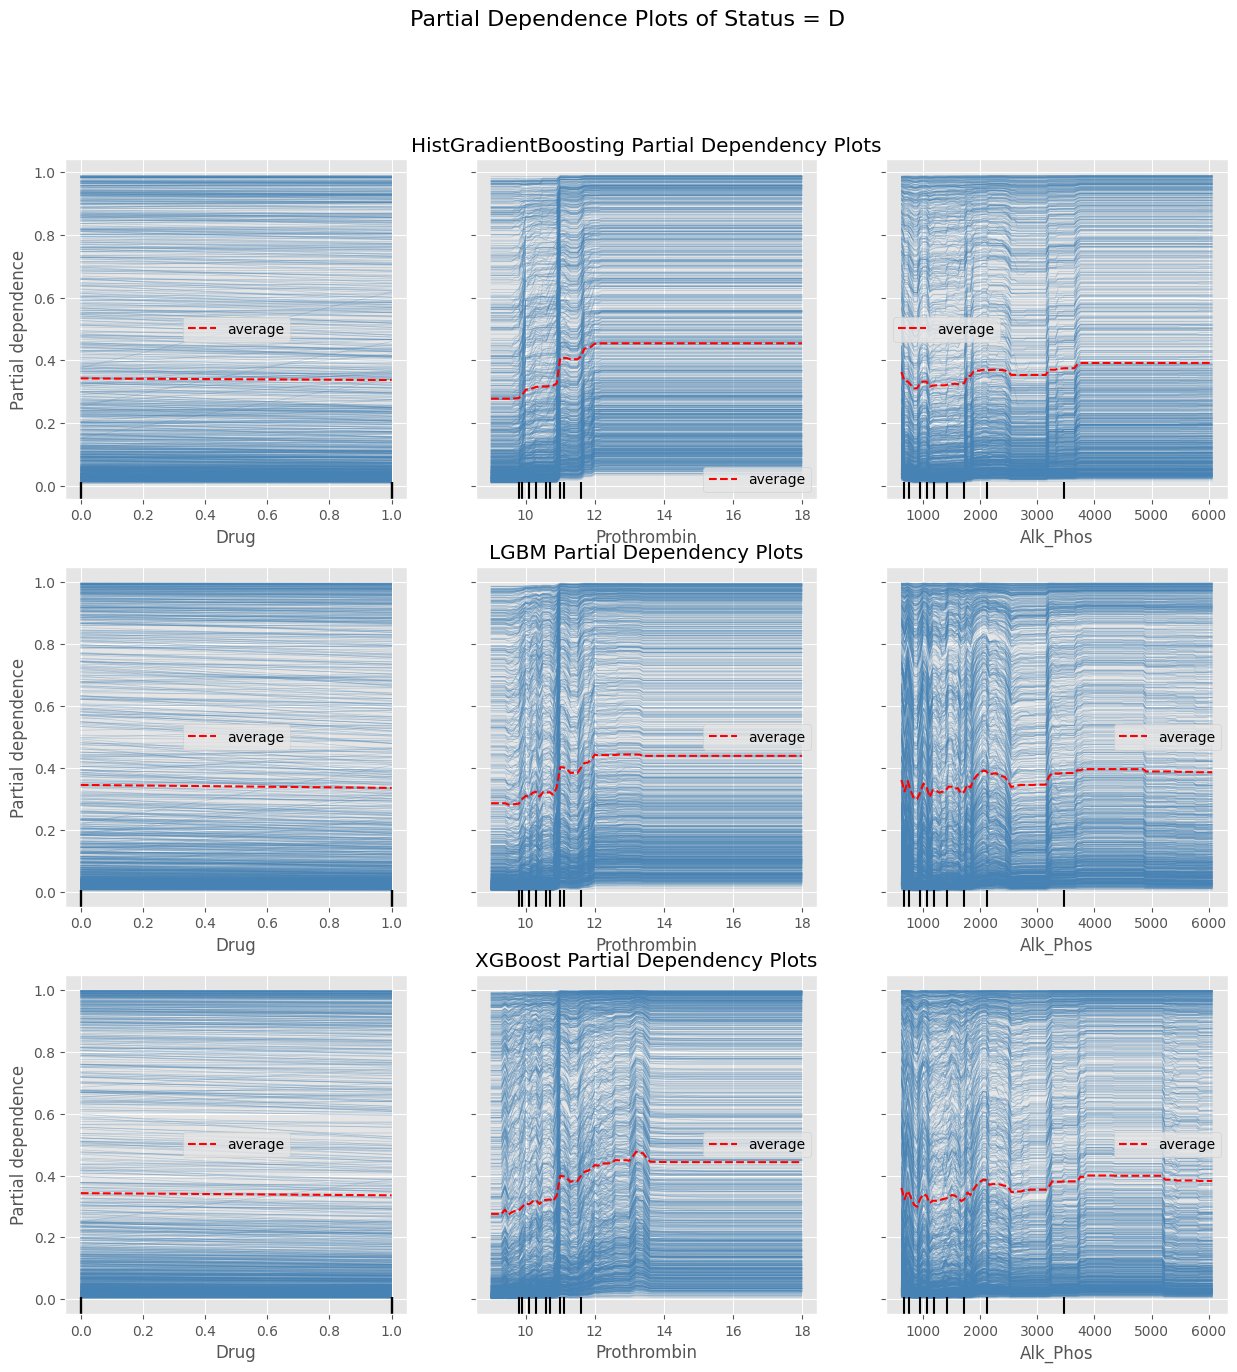

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 15))

fig.suptitle('Partial Dependence Plots of Status = D', fontsize = 16)

HG_disp = PartialDependenceDisplay.from_estimator(md4_fit, X, ['Drug', 'Prothrombin', 'Alk_Phos'],
                                                  pd_line_kw = {"color": "red"},
                                                  ice_lines_kw = {"color": "steelblue"},
                                                  kind = 'both', 
                                                  target = 2,
                                                  response_method = 'predict_proba',
                                                  ax = ax1)
ax1.set_title('HistGradientBoosting Partial Dependency Plots')

LGBM_disp = PartialDependenceDisplay.from_estimator(md5_fit, X, ['Drug', 'Prothrombin', 'Alk_Phos'],
                                                    pd_line_kw = {"color": "red"},
                                                    ice_lines_kw = {"color": "steelblue"},
                                                    kind = 'both', 
                                                    target = 2,
                                                    response_method = 'predict_proba',
                                                    ax = ax2)
ax2.set_title('LGBM Partial Dependency Plots')

XGB_disp = PartialDependenceDisplay.from_estimator(md6_fit, X, ['Drug', 'Prothrombin', 'Alk_Phos'],
                                                   pd_line_kw = {"color": "red"},
                                                   ice_lines_kw = {"color": "steelblue"},
                                                   kind = 'both', 
                                                   target = 2,
                                                   response_method = 'predict_proba',
                                                   ax = ax3)
ax3.set_title('XGBoost Partial Dependency Plots')
plt.savefig('D_partial_dependency_plots.png');

From the above plots, these are a couple of observations:

- The mean likelihood of `Status = D` is constant regardless of `Drug` label.
- When `Prothrombin >= 14`, the mean likelihood of `Status = C` is constant. 
- When `Alk_Phos >= 4000`, the mean likelihood of `Status = C` is pretty flat.

Based on the partial dependency plots, we proceed to clip `Prothrombin` and `Alk_Phos`.

In [33]:
X_clipped = X.drop(columns = ['Drug'], axis = 1).copy()
X_clipped['Prothrombin'] = X_clipped['Prothrombin'].clip(None, 12)
X_clipped['Alk_Phos'] = X_clipped['Alk_Phos'].clip(None, 4000)

X_clipped_xgb = X.drop(columns = ['Drug'], axis = 1).copy()
X_clipped_xgb['Prothrombin'] = X_clipped_xgb['Prothrombin'].clip(None, 14)
X_clipped_xgb['Alk_Phos'] = X_clipped_xgb['Alk_Phos'].clip(None, 4000)

In [34]:
%%time
HB_cv_clipped = cross_val_score(HistGradientBoostingClassifier(**{'l2_regularization': 6.000578252212072,
                                                                  'early_stopping': False,
                                                                  'learning_rate': 0.06573007107547826,
                                                                  'max_iter': 500,
                                                                  'max_depth': 18,
                                                                  'max_bins': 255,
                                                                  'min_samples_leaf': 10,
                                                                  'max_leaf_nodes': 5,
                                                                  'random_state': 3}),
                        X_clipped, 
                        Y, 
                        scoring = 'neg_log_loss',
                        cv = skf, 
                        n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the HG (clipped) is {-1*HB_cv_clipped.mean()}")

The average 10-folds oof Log-Loss score of the HG (clipped) is 0.43511603762321577
CPU times: user 29.9 s, sys: 0 ns, total: 29.9 s
Wall time: 29.9 s


In [35]:
%%time
LGBM_cv_clipped = cross_val_score(LGBMClassifier(**{'n_estimators': 1000,
                                                    'learning_rate': 0.009234851395058207,
                                                    'max_depth': 15,
                                                    'reg_alpha': 0.09277531052671233,
                                                    'reg_lambda': 4.3009124728947254,
                                                    'num_leaves': 43,
                                                    'subsample': 0.8530702473475602,
                                                    'colsample_bytree': 0.2405420793375799}),
                          X_clipped,
                          Y,
                          scoring = 'neg_log_loss',
                          cv = skf, 
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the LGBM model is {-1*LGBM_cv_clipped.mean()}") 

The average 10-folds oof Log-Loss score of the LGBM model is 0.4164579051197336
CPU times: user 4min 43s, sys: 3min 41s, total: 8min 25s
Wall time: 5min 46s


In [36]:
%%time
XGB_cv_clipped = cross_val_score(XGBClassifier(**{'max_depth': 7,
                                                  'learning_rate': 0.03570188608151033,
                                                  'n_estimators': 1000,
                                                  'gamma': 0.6440001307764849,
                                                  'min_child_weight': 2,
                                                  'colsample_bytree': 0.27034458854562116,
                                                  'subsample': 0.8435412915999765}), 
                          X_clipped_xgb,
                          Y,
                          scoring = 'neg_log_loss',
                          cv = skf, 
                          n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the XGBoost model is {-1*XGB_cv_clipped.mean()}") 

The average 10-folds oof Log-Loss score of the XGBoost model is 0.41841714116672957
CPU times: user 54.5 s, sys: 603 ms, total: 55.1 s
Wall time: 55.2 s


In [37]:
model_performance_comp = pd.DataFrame()
model_performance_comp['Model'] = ['Hist', 'LGBM', 'XGBoost']
model_performance_comp['10-folds oof Log-Loss'] = [-1*HB_cv.mean(), -1*LGBM_cv.mean(), -1*XGB_cv.mean()]
model_performance_comp['10-folds oof Log-Loss (clipped)'] = [-1*HB_cv_clipped.mean(), -1*LGBM_cv_clipped.mean(), -1*XGB_cv_clipped.mean()]
print(f"The followig table shows the compare the performance of the considered models: \n\n{model_performance_comp}")

The followig table shows the compare the performance of the considered models: 

     Model  10-folds oof Log-Loss  10-folds oof Log-Loss (clipped)
0     Hist               0.438258                         0.435116
1     LGBM               0.418989                         0.416458
2  XGBoost               0.419205                         0.418417


In [38]:
md4_clip = HistGradientBoostingClassifier(**{'l2_regularization': 6.000578252212072,
                                             'early_stopping': False,
                                             'learning_rate': 0.06573007107547826,
                                             'max_iter': 500,
                                             'max_depth': 18,
                                             'max_bins': 255,
                                             'min_samples_leaf': 10,
                                             'max_leaf_nodes': 5,
                                             'random_state': 3})


md5_clip = LGBMClassifier(**{'n_estimators': 1000,
                             'learning_rate': 0.009234851395058207,
                             'max_depth': 15,
                             'reg_alpha': 0.09277531052671233,
                             'reg_lambda': 4.3009124728947254,
                             'num_leaves': 43,
                             'subsample': 0.8530702473475602,
                             'colsample_bytree': 0.2405420793375799})

md6_clip = XGBClassifier(**{'max_depth': 7,
                            'learning_rate': 0.03570188608151033,
                            'n_estimators': 1000,
                            'gamma': 0.6440001307764849,
                            'min_child_weight': 2,
                            'colsample_bytree': 0.27034458854562116,
                            'subsample': 0.8435412915999765})

In [39]:
%%time
md4_pred_clip, md5_pred_clip, md6_pred_clip = list(), list(), list()
Y_test_list = list()

for i, (train_idx, test_idx) in enumerate(skf.split(X_clipped, Y)):

    X_train_clip, X_test_clip = X_clipped.iloc[train_idx], X_clipped.iloc[test_idx]
    X_train_clip_xgb, X_test_clip_xgb = X_clipped_xgb.iloc[train_idx], X_clipped_xgb.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    md4_clip.fit(X_train_clip, Y_train)
    md4_pred_clip.append(md4_clip.predict_proba(X_test_clip))
    
    md5_clip.fit(X_train_clip, Y_train)
    md5_pred_clip.append(md5_clip.predict_proba(X_test_clip))
    
    md6_clip.fit(X_train_clip_xgb, Y_train)
    md6_pred_clip.append(md6_clip.predict_proba(X_test_clip_xgb))
    
    Y_test_list.append(Y_test)

CPU times: user 5min 51s, sys: 3min 38s, total: 9min 29s
Wall time: 7min


In [40]:
w4_weights_clip, w5_weights_clip, w6_weights_clip = list(), list(), list()
scores = list()

for i in tqdm(range(0, 5000)):
    
    w4 = np.random.random_sample(size = 1)[0]
    w5 = np.random.random_sample(size = 1)[0]
    w6 = np.random.random_sample(size = 1)[0]
    
    w4_weights_clip.append(w4)
    w5_weights_clip.append(w5)
    w6_weights_clip.append(w6)
    
    scores_in = list()
    
    for j in range(0, 10):
        
        pred = w4*md4_pred_clip[j] + w5*md5_pred_clip[j] + w6*md6_pred_clip[j] 
        scores_in.append(log_loss(Y_test_list[j], pred))
    
    scores.append(np.mean(scores_in))
    
results_clip = pd.DataFrame()
results_clip['w_md4'] = w4_weights_clip
results_clip['w_md5'] = w5_weights_clip
results_clip['w_md6'] = w6_weights_clip
results_clip['score'] = scores
results_clip = results_clip.sort_values(by = 'score', ascending = True).reset_index(drop = True)
results_clip.head(10)

  0%|          | 0/5000 [00:00<?, ?it/s]

w_md4     w_md5     w_md6     score
0  0.001742  0.725645  0.484240  0.416008
1  0.006199  0.827664  0.325346  0.416027
2  0.002332  0.668073  0.549550  0.416056
3  0.012665  0.756925  0.467299  0.416073
4  0.014321  0.695697  0.478028  0.416084
5  0.003023  0.780640  0.501883  0.416085
6  0.008464  0.800500  0.298436  0.416097
7  0.005041  0.822144  0.463081  0.416098
8  0.016228  0.920409  0.267704  0.416100
9  0.011328  0.693290  0.421965  0.416114

In [41]:
%%time
md4_fit_clip = md4_clip.fit(X_clipped, Y)
md5_fit_clip = md5_clip.fit(X_clipped, Y)
md6_fit_clip = md6_clip.fit(X_clipped_xgb, Y)

CPU times: user 37.8 s, sys: 23.4 s, total: 1min 1s
Wall time: 45.1 s


In [42]:
test_md_clipped = test_md.drop(columns = ['Drug'], axis = 1).copy()
test_md_clipped['Prothrombin'] = test_md_clipped['Prothrombin'].clip(None, 12)
test_md_clipped['Alk_Phos'] = test_md_clipped['Alk_Phos'].clip(None, 4000)

test_md_clipped_xgb = test_md.drop(columns = ['Drug'], axis = 1).copy()
test_md_clipped_xgb['Prothrombin'] = test_md_clipped_xgb['Prothrombin'].clip(None, 14)
test_md_clipped_xgb['Alk_Phos'] = test_md_clipped_xgb['Alk_Phos'].clip(None, 4000)

ens_clip = (results_clip['w_md4'][0]*md4_fit_clip.predict_proba(test_md_clipped) + 
            results_clip['w_md5'][0]*md5_fit_clip.predict_proba(test_md_clipped) + 
            results_clip['w_md6'][0]*md6_fit_clip.predict_proba(test_md_clipped_xgb)) 

ens_clip = pd.DataFrame(ens_clip)
ens_clip = ens_clip.div(ens_clip.sum(axis = 1), axis = 0)

submission.loc[:, ['Status_C', 'Status_CL', 'Status_D']] = ens_clip.values
submission.head()

id  Status_C  Status_CL  Status_D
0  7905  0.434723   0.021424  0.543853
1  7906  0.538458   0.194542  0.266999
2  7907  0.029027   0.007747  0.963225
3  7908  0.969270   0.003846  0.026883
4  7909  0.879480   0.036921  0.083599

In [43]:
submission.to_csv('baseline_sub_2.csv', index = False)

<a id="7"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 3.0</h1>

In this section, we continue exploring ideas to boost model performance. We start by exploring the distribution of the numerical features.

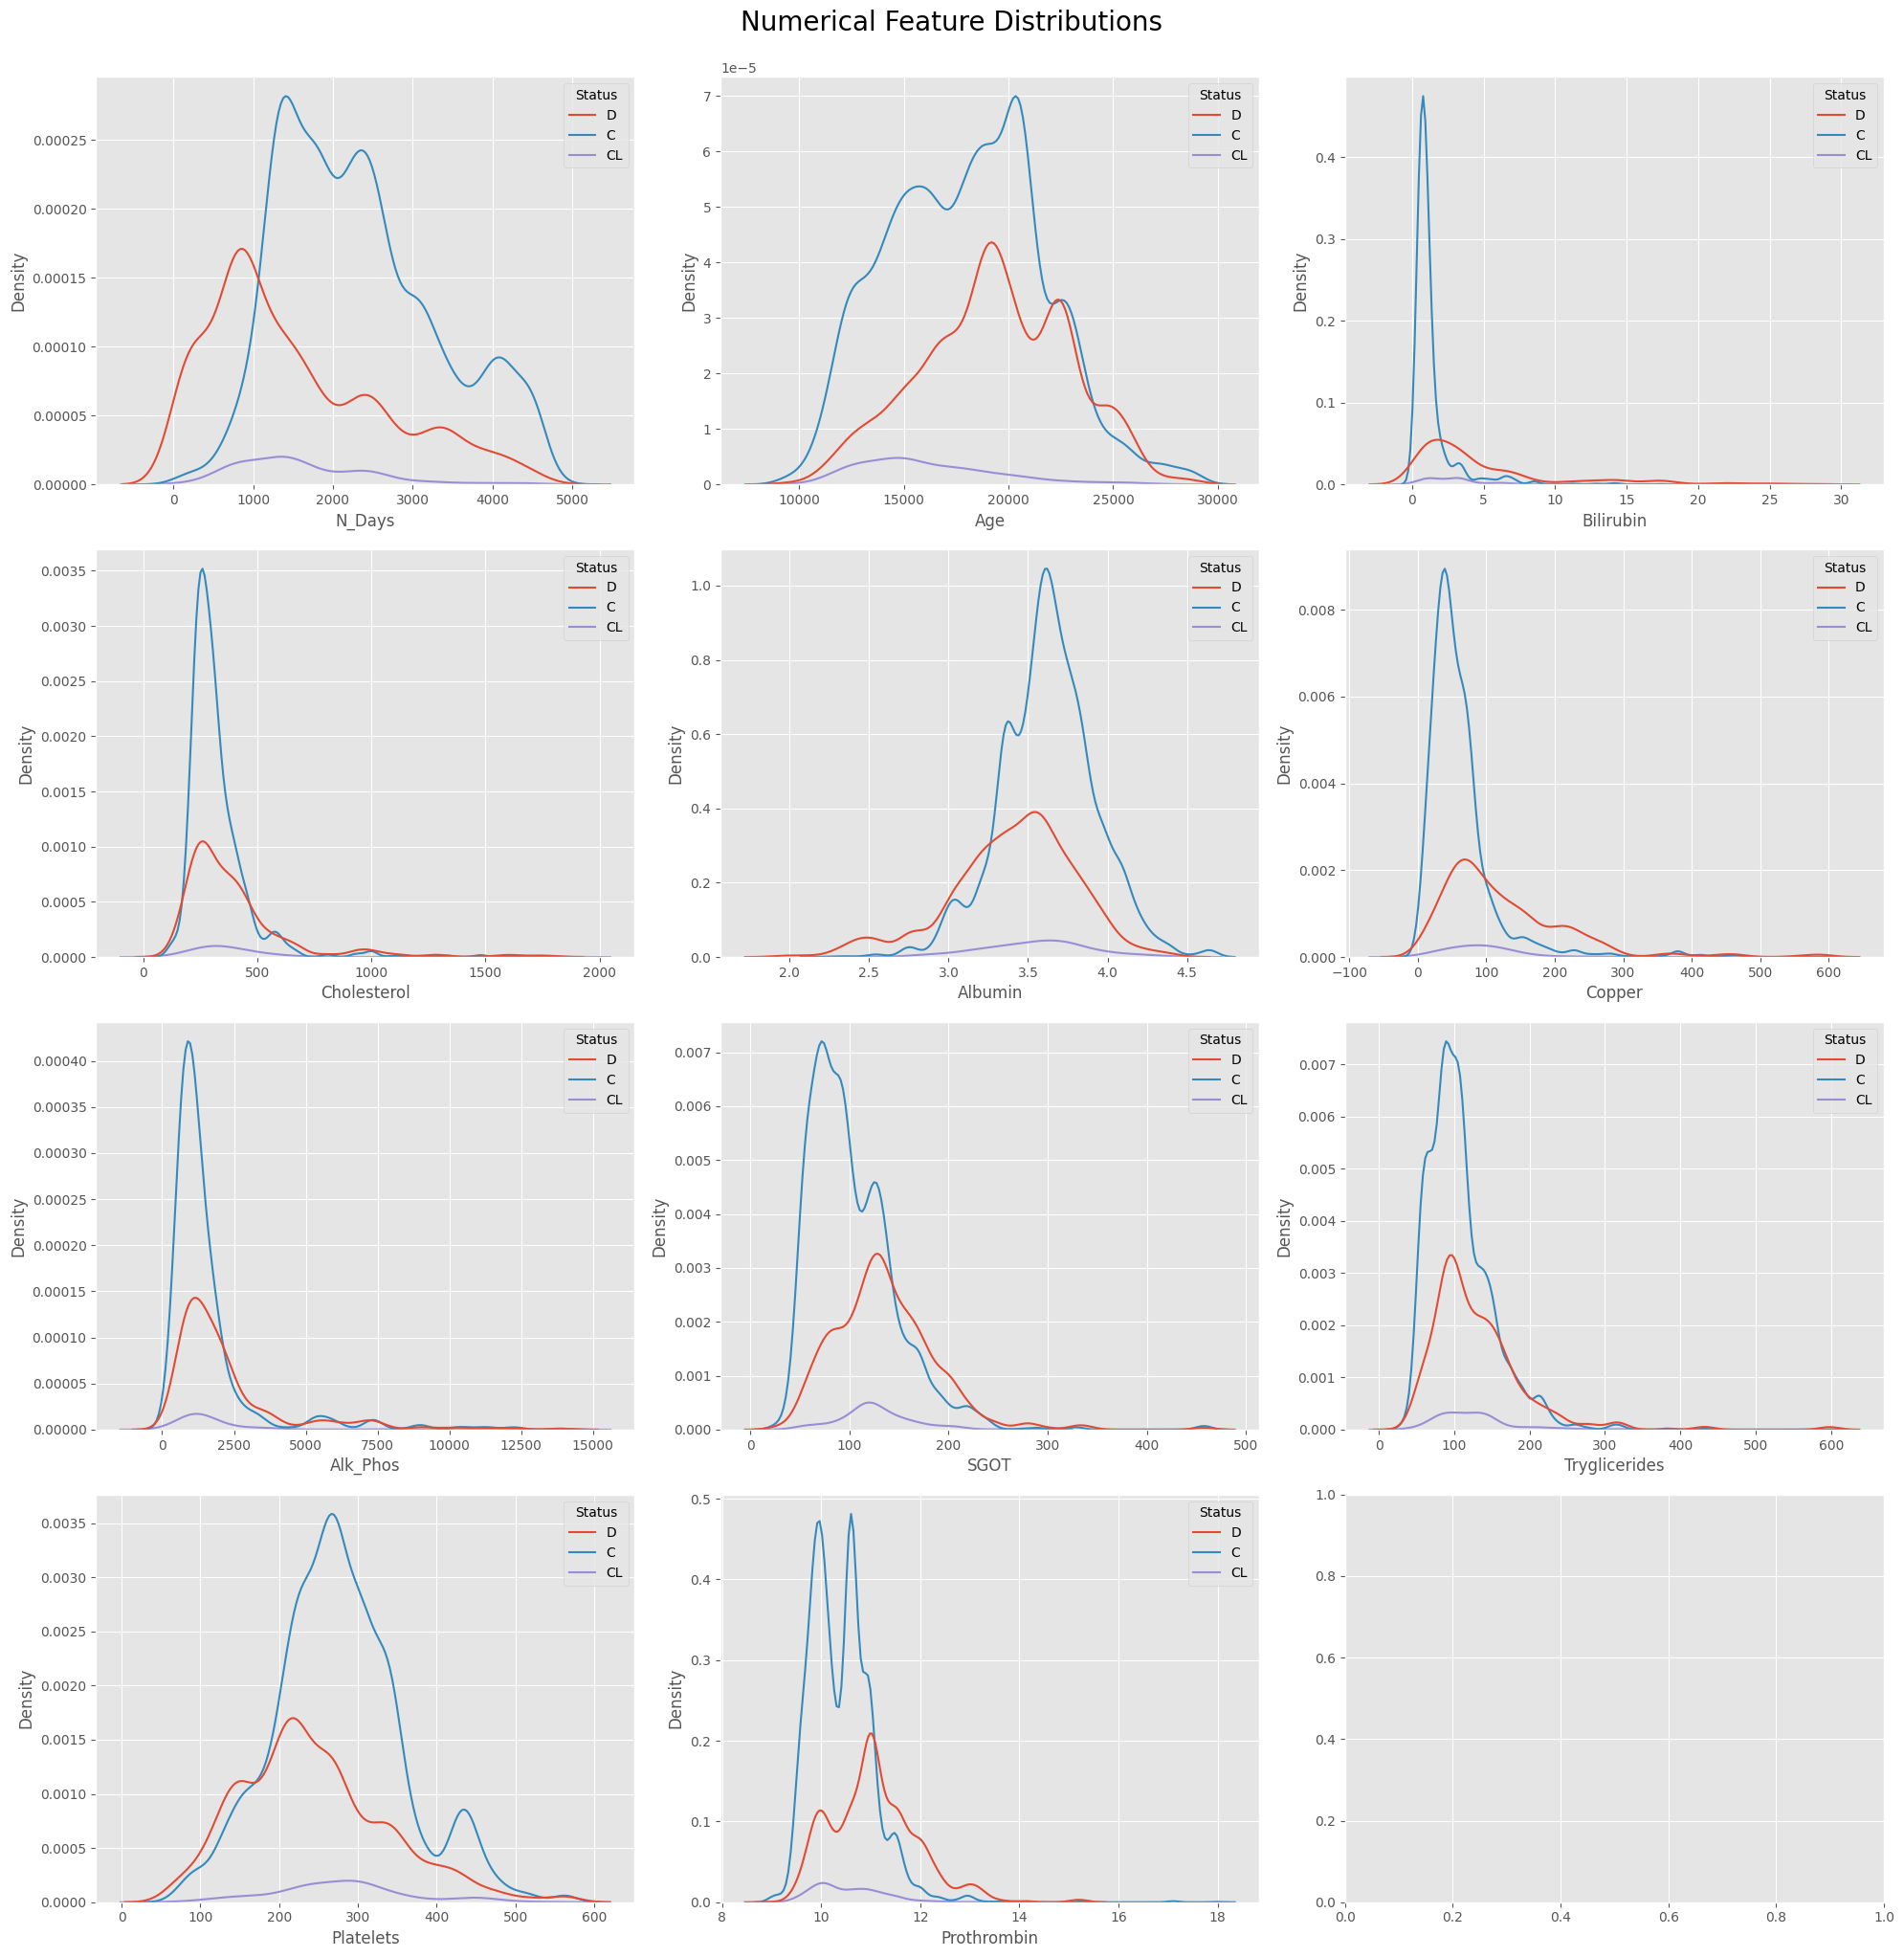

In [44]:
to_plot = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
           'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin'] 

_, axs = plt.subplots(4, 3, figsize = (20, 20))
for col, ax in zip(to_plot, axs.ravel()):
    sns.kdeplot(ax = ax, x = train[col], hue = train['Status']);   
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Numerical Feature Distributions', y = 1.02, fontsize = 20)
plt.savefig('Numerical_Feature_Distributions.png')
plt.show();

From the above plots, we can see that most of the distributions are skewed. Thus, we will explore if transforming the input features can help with model performance. From the previous section, we know `LGBMClassifier` is the best model based on the experiments that I've performed. So, we will focus on transforming/scaling the input features to see the effect on the performance of `LGBMClassifier`. We consider three popular transformations: `MinMaxScaler`, `StandardScaler`, and `Log-Transformation`.

In [45]:
X = train.drop(columns = ['Edema', 'Status', 'Drug'], axis = 1)
X['Sex'] = X['Sex'].map({'F': 0, 'M': 1})
X['Ascites'] = X['Ascites'].map({'N': 0, 'Y': 1})
X['Hepatomegaly'] = X['Hepatomegaly'].map({'N': 0, 'Y': 1})
X['Spiders'] = X['Spiders'].map({'N': 0, 'Y': 1})
X = pd.concat([X, pd.get_dummies(train['Edema'], drop_first = True, dtype = int)], axis = 1)

Y = train['Status'].map({'C': 0, 'CL': 1, 'D': 2})

test_md = test.drop(columns = ['Edema', 'Drug'], axis = 1)
test_md['Sex'] = test_md['Sex'].map({'F': 0, 'M': 1})
test_md['Ascites'] = test_md['Ascites'].map({'N': 0, 'Y': 1})
test_md['Hepatomegaly'] = test_md['Hepatomegaly'].map({'N': 0, 'Y': 1})
test_md['Spiders'] = test_md['Spiders'].map({'N': 0, 'Y': 1})
test_md = pd.concat([test_md, pd.get_dummies(test['Edema'], drop_first = True, dtype = int)], axis = 1)

X['Prothrombin'] = X['Prothrombin'].clip(None, 12)
X['Alk_Phos'] = X['Alk_Phos'].clip(None, 4000)

test_md['Prothrombin'] = test_md['Prothrombin'].clip(None, 12)
test_md['Alk_Phos'] = test_md['Alk_Phos'].clip(None, 4000)

First, we consider the `MinMaxScaler` transformation.

In [46]:
%%time
md1 = make_pipeline(MinMaxScaler(), LGBMClassifier(**{'n_estimators': 575,
                                                      'learning_rate': 0.01732606738538729,
                                                      'max_depth': 13,
                                                      'reg_alpha': 1.9107864265800503,
                                                      'reg_lambda': 0.3750064227973666,
                                                      'num_leaves': 90,
                                                      'subsample': 0.6570428188464579,
                                                      'colsample_bytree': 0.13320976812652405}))

LGBM_min_max_cv = cross_val_score(md1, 
                                  X, 
                                  Y, 
                                  scoring = 'neg_log_loss',
                                  cv = skf, 
                                  n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the LGBM (clipped & Min-Max) is {-1*LGBM_min_max_cv.mean()}")

The average 10-folds oof Log-Loss score of the LGBM (clipped & Min-Max) is 0.4117198692065617
CPU times: user 2min 27s, sys: 2min 7s, total: 4min 35s
Wall time: 3min 16s


Next, we consider the `StandardScaler` transformation.

In [47]:
%%time
to_tran = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
           'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin'] 

stan_tran = ColumnTransformer([('stand', StandardScaler(), to_tran)],
                               remainder = 'passthrough')


md2 = Pipeline([('tran', stan_tran), 
                ('model', LGBMClassifier(**{'n_estimators': 636,
                                            'learning_rate': 0.015707764414707382,
                                            'max_depth': 15,
                                            'reg_alpha': 0.4517695850734022,
                                            'reg_lambda': 1.2689834366463586,
                                            'num_leaves': 52,
                                            'subsample': 0.8323150231782891,
                                            'colsample_bytree': 0.17176237382953963}))])

LGBM_stand_cv = cross_val_score(md2, 
                                X, 
                                Y, 
                                scoring = 'neg_log_loss',
                                cv = skf, 
                                n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the LGBM (clipped & StandardScaler) is {-1*LGBM_stand_cv.mean()}")

The average 10-folds oof Log-Loss score of the LGBM (clipped & StandardScaler) is 0.4118290856828728
CPU times: user 2min 35s, sys: 2min 11s, total: 4min 47s
Wall time: 3min 26s


Next, we consider the `Log1p` transformation.

In [48]:
%%time
log_tran = ColumnTransformer([('log', FunctionTransformer(np.log1p), to_tran)],
                               remainder = 'passthrough')

md3 = Pipeline([('log-tran', log_tran), 
                ('model', LGBMClassifier(**{'n_estimators': 957,
                                            'learning_rate': 0.00951061618483829,
                                            'max_depth': 18,
                                            'reg_alpha': 1.4932102588695442,
                                            'reg_lambda': 0.015034385736399756,
                                            'num_leaves': 100,
                                            'subsample': 0.6007345854580594,
                                            'colsample_bytree': 0.1580107227348286}))])

LGBM_log_cv = cross_val_score(md3, 
                              X, 
                              Y, 
                              scoring = 'neg_log_loss',
                              cv = skf, 
                              n_jobs = -1)

print(f"The average 10-folds oof Log-Loss score of the LGBM (clipped & Log1p) is {-1*LGBM_log_cv.mean()}")

The average 10-folds oof Log-Loss score of the LGBM (clipped & Log1p) is 0.41248745064374315
CPU times: user 4min 41s, sys: 4min 10s, total: 8min 52s
Wall time: 6min 23s


In [49]:
model_performance_comp = pd.DataFrame()
model_performance_comp['Input-Features'] = ['Raw', 'Clipped', 'Clipped & Min-Max', 'Clipped & StandardScaler', 'Clipped & Log1p']
model_performance_comp['LGBM 10-folds oof Log-Loss'] = [-1*LGBM_cv.mean(), -1*LGBM_cv_clipped.mean(), -1*LGBM_min_max_cv.mean(), -1*LGBM_stand_cv.mean(), -1*LGBM_log_cv.mean()]
print(f"The followig table shows the compare the performance of the considered models: \n\n{model_performance_comp}")

The followig table shows the compare the performance of the considered models: 

             Input-Features  LGBM 10-folds oof Log-Loss
0                       Raw                    0.418989
1                   Clipped                    0.416458
2         Clipped & Min-Max                    0.411720
3  Clipped & StandardScaler                    0.411829
4           Clipped & Log1p                    0.412487


In [50]:
%%time
md1_pred, md2_pred, md3_pred = list(), list(), list()
Y_test_list = list()

for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    md1.fit(X_train, Y_train)
    md1_pred.append(md1.predict_proba(X_test))
    
    md2.fit(X_train, Y_train)
    md2_pred.append(md2.predict_proba(X_test))
    
    md3.fit(X_train, Y_train)
    md3_pred.append(md3.predict_proba(X_test))
    
    Y_test_list.append(Y_test)

CPU times: user 9min 42s, sys: 8min 32s, total: 18min 14s
Wall time: 13min 2s


In [51]:
w1_weights, w2_weights, w3_weights = list(), list(), list()
scores = list()

for i in tqdm(range(0, 5000)):
    
    w1 = np.random.random_sample(size = 1)[0]
    w2 = np.random.random_sample(size = 1)[0]
    w3 = np.random.random_sample(size = 1)[0]
    
    w1_weights.append(w1)
    w2_weights.append(w2)
    w3_weights.append(w3)
    
    scores_in = list()
    
    for j in range(0, 10):
        
        pred = w1*md1_pred[j] + w2*md2_pred[j] + w3*md3_pred[j] 
        scores_in.append(log_loss(Y_test_list[j], pred))
    
    scores.append(np.mean(scores_in))
    
results_clip_tran = pd.DataFrame()
results_clip_tran['w_md1'] = w1_weights
results_clip_tran['w_md2'] = w2_weights
results_clip_tran['w_md3'] = w3_weights
results_clip_tran['score'] = scores
results_clip_tran = results_clip_tran.sort_values(by = 'score', ascending = True).reset_index(drop = True)
results_clip_tran.head(10)

  0%|          | 0/5000 [00:00<?, ?it/s]

w_md1     w_md2     w_md3     score
0  0.498923  0.527978  0.003504  0.410986
1  0.320933  0.258470  0.001112  0.410993
2  0.477458  0.409729  0.010939  0.410996
3  0.430181  0.498040  0.017670  0.411001
4  0.386635  0.440712  0.022498  0.411006
5  0.444124  0.568934  0.017171  0.411007
6  0.522139  0.459757  0.034823  0.411012
7  0.579841  0.395925  0.005053  0.411013
8  0.143538  0.152321  0.012844  0.411015
9  0.482683  0.457950  0.041198  0.411015

In [52]:
%%time
md1_fit_clip_tran = md1.fit(X, Y)
md2_fit_clip_tran = md2.fit(X, Y)
md3_fit_clip_tran = md3.fit(X, Y)

CPU times: user 58.7 s, sys: 51 s, total: 1min 49s
Wall time: 1min 17s


In [53]:
ens_clip_tran = (results_clip_tran['w_md1'][0]*md1_fit_clip_tran.predict_proba(test_md) +
                 results_clip_tran['w_md2'][0]*md2_fit_clip_tran.predict_proba(test_md) + 
                 results_clip_tran['w_md3'][0]*md3_fit_clip_tran.predict_proba(test_md)) 

ens_clip_tran = pd.DataFrame(ens_clip_tran)
ens_clip_tran = ens_clip_tran.div(ens_clip_tran.sum(axis = 1), axis = 0)

submission.loc[:, ['Status_C', 'Status_CL', 'Status_D']] = ens_clip_tran.values
submission.head()

id  Status_C  Status_CL  Status_D
0  7905  0.361404   0.026036  0.612560
1  7906  0.504392   0.150979  0.344629
2  7907  0.037545   0.008932  0.953523
3  7908  0.975150   0.002932  0.021918
4  7909  0.874321   0.050564  0.075115

In [54]:
submission.to_csv('baseline_sub_3.csv', index = False)

<a id="8"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Ensemble Modeling </h1>

In this section, we ensemble the prediction of the previos sections.

In [55]:
submission.loc[:, ['Status_C', 'Status_CL', 'Status_D']] = (ens.values + ens_clip.values + ens_clip_tran.values) / 3
submission.head()

id  Status_C  Status_CL  Status_D
0  7905  0.408048   0.025503  0.566449
1  7906  0.508101   0.191951  0.299948
2  7907  0.030519   0.008466  0.961015
3  7908  0.970765   0.003486  0.025749
4  7909  0.878359   0.042268  0.079374

In [56]:
submission.to_csv('ensemble_sub.csv', index = False)